In [ ]:
import numpy as np
import pandas as pd
import shap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

import matplotlib.pyplot as plt

# Train XGBoost with Different Feature Sets

In [2]:
# df = pd.read_csv('data/nba_data_for_train.csv')
df = pd.read_csv('data/df_train_without_pg.csv')

In [ ]:
feature_sets = {
    'with_high_corr_low_features':['MIN_PG', 'PF_PG', 'STL_PG', 'PTS_PG', 'FGM_PG', 'FGA_PG', 'BLK_PG', 'PLUS_MINUS_PG', 'PFD_PG', 'TOV_PG', 'DREB_PG', 'REB_PG', 'OREB_PG',
                                   'FTM_PG', 'FTA_PG', 'EXP', 'POSS', 'AGE', 'HEIGHT', 'WEIGHT', 'BMI', 'USG_PCT', 'PIE', 'E_OFF_RATING', 'E_DEF_RATING', 'AST_TO', 'AST_RATIO'],
    'with_low_features': ['MIN_PG', 'STL_PG', 'PTS_PG', 'BLK_PG', 'PLUS_MINUS_PG', 'PFD_PG', 'TOV_PG', 'DREB_PG', 'REB_PG', 'OREB_PG', 
                          'FTM_PG', 'FTA_PG', 'EXP', 'AGE', 'HEIGHT', 'WEIGHT', 'BMI', 'USG_PCT', 'PIE', 'E_OFF_RATING', 'E_DEF_RATING', 'AST_TO', 'AST_RATIO'],
    'with_high_corr_features': ['MIN_PG', 'PF_PG', 'STL_PG', 'PTS_PG', 'FGM_PG', 'FGA_PG', 'BLK_PG', 'PLUS_MINUS_PG', 'PFD_PG', 'TOV_PG', 'DREB_PG', 'REB_PG', 'OREB_PG',
                                'EXP', 'POSS', 'AGE', 'HEIGHT', 'WEIGHT', 'BMI'],
    'with_high_corr_no_pf_features': ['MIN_PG', 'STL_PG', 'PTS_PG', 'FGM_PG', 'FGA_PG', 'BLK_PG', 'PLUS_MINUS_PG', 'PFD_PG', 'TOV_PG', 'DREB_PG', 'REB_PG', 'OREB_PG',
                                      'EXP', 'POSS', 'AGE', 'HEIGHT', 'WEIGHT', 'BMI'], # -plus minus, -poss, 
    'with_high_corr_no_pf_fg_features': ['MIN_PG', 'STL_PG', 'PTS_PG', 'BLK_PG', 'PLUS_MINUS_PG', 'PFD_PG', 'TOV_PG', 'DREB_PG', 'REB_PG', 'OREB_PG',
                                      'EXP', 'POSS', 'AGE', 'HEIGHT', 'WEIGHT', 'BMI'],
    'without_high_corr_low_features': ['MIN_PG', 'STL_PG', 'PTS_PG', 'BLK_PG', 'PLUS_MINUS_PG', 'PFD_PG', 'TOV_PG', 'DREB_PG', 'REB_PG', 'OREB_PG',
                                      'EXP', 'AGE', 'HEIGHT', 'WEIGHT', 'BMI']
}

# feature_sets = {
#     'with_high_corr_low_features': ['MIN', 'PF', 'STL', 'PTS', 'FGM', 'FGA', 'BLK', 'PLUS_MINUS', 'PFD', 'TOV', 'DREB', 'REB', 'OREB',
#                                     'FTM', 'FTA', 'EXP', 'POSS', 'AGE', 'HEIGHT', 'WEIGHT', 'BMI', 'USG_PCT', 'PIE', 'E_OFF_RATING', 'E_DEF_RATING', 'AST_TO', 'AST_RATIO'],
#     'with_low_features': ['MIN', 'STL', 'PTS', 'BLK', 'PLUS_MINUS', 'PFD', 'TOV', 'DREB', 'REB', 'OREB',
#                           'FTM', 'FTA', 'EXP', 'AGE', 'HEIGHT', 'WEIGHT', 'BMI', 'USG_PCT', 'PIE', 'E_OFF_RATING', 'E_DEF_RATING', 'AST_TO', 'AST_RATIO'],
#     'with_high_corr_features': ['MIN', 'PF', 'STL', 'PTS', 'FGM', 'FGA', 'BLK', 'PLUS_MINUS', 'PFD', 'TOV', 'DREB', 'REB', 'OREB',
#                                 'EXP', 'POSS', 'AGE', 'HEIGHT', 'WEIGHT', 'BMI'],
#     'with_high_corr_no_pf_features': ['MIN', 'STL', 'PTS', 'FGM', 'FGA', 'BLK', 'PLUS_MINUS', 'PFD', 'TOV', 'DREB', 'REB', 'OREB',
#                                       'EXP', 'POSS', 'AGE', 'HEIGHT', 'WEIGHT', 'BMI'],
#     'without_high_corr_low_features': ['MIN', 'STL', 'PTS', 'BLK', 'PLUS_MINUS', 'PFD', 'TOV', 'DREB', 'REB', 'OREB',
#                                        'EXP', 'AGE', 'HEIGHT', 'WEIGHT', 'BMI']
# }
# df_prep_for_Pval=df_prep[['AGE','TEAM_ID','MIN','FGA','FG3M','FG3A','FTM','FTA','OREB','DREB','REB','AST',
#                    'TOV','STL','BLK','BLKA','PF','PFD','PTS','EXP','Games Missed','HEIGHT','WEIGHT']]

In [ ]:
def evaluate_feature_set(df, feature_list, target_col, param_grid=None, random_state=42):
    """
    Trains and evaluates an XGBRegressor model using the given feature list and target.
    Optionally performs hyperparameter tuning with param_grid (for GridSearchCV).
    Returns the trained model, plus a dictionary of relevant metrics and the best parameters found (if any).
    """
    
    # Subset the data
    X = df[feature_list].copy()
    y = df[target_col].copy()
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )
    
    # Define a base model
    xgb_reg = XGBRegressor(random_state=random_state)
    
    # If param_grid is provided, run hyperparameter tuning
    if param_grid:
        grid_search = GridSearchCV(
            estimator=xgb_reg,
            param_grid=param_grid,
            scoring='neg_mean_squared_error',
            cv=3,
            verbose=1,
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
    else:
        best_model = xgb_reg
        best_model.fit(X_train, y_train)
        best_params = None
    
    # Predict on test set
    y_pred = best_model.predict(X_test)
    
    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Return results
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }
    
    return best_model, metrics, best_params

In [ ]:
param_grid_set = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1],
}

results = {}
TARGET = 'Games Missed'

use_param_grid = param_grid_set

for set_name, features in feature_sets.items():
    print(f"Evaluating feature set: {set_name}")
    
    model, metrics, best_params = evaluate_feature_set(
        df=df,
        feature_list=features,
        target_col=TARGET,
        param_grid=use_param_grid, 
        random_state=42
    )

    results[set_name] = {
        'Features': features,
        'MSE': metrics['MSE'],
        'RMSE': metrics['RMSE'],
        'R2': metrics['R2'],
        'Best Params': best_params
    }

results_df = pd.DataFrame(results).T
results_df

NameError: name 'feature_sets' is not defined

# Without PG Data

In [ ]:
results1 = {}
TARGET = 'Games Missed'

use_param_grid = param_grid_set

for set_name, features in feature_sets.items():
    print(f"Evaluating feature set: {set_name}")
    
    model, metrics, best_params = evaluate_feature_set(
        df=df,
        feature_list=features,
        target_col=TARGET,
        param_grid=use_param_grid,
        random_state=42
    )

    results1[set_name] = {
        'Features': features,
        'MSE': metrics['MSE'],
        'RMSE': metrics['RMSE'],
        'R2': metrics['R2'],
        'Best Params': best_params
    }

results_df1 = pd.DataFrame(results1).T
results_df1

Evaluating feature set: with_high_corr_low_features
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Evaluating feature set: with_low_features
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Evaluating feature set: with_high_corr_features
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Evaluating feature set: with_high_corr_no_pf_features
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Evaluating feature set: without_high_corr_low_features
Fitting 3 folds for each of 108 candidates, totalling 324 fits


,Features,MSE,RMSE,R2,Best Params
with_high_corr_low_features,"[MIN, PF, STL, PTS, FGM, FGA, BLK, PLUS_MINUS,...",146.737685,12.113533,0.18329,"{'colsample_bytree': 0.7, 'learning_rate': 0.1..."
with_low_features,"[MIN, STL, PTS, BLK, PLUS_MINUS, PFD, TOV, DRE...",141.031323,11.875661,0.215051,"{'colsample_bytree': 1, 'learning_rate': 0.01,..."
with_high_corr_features,"[MIN, PF, STL, PTS, FGM, FGA, BLK, PLUS_MINUS,...",146.179002,12.090451,0.1864,"{'colsample_bytree': 0.7, 'learning_rate': 0.0..."
with_high_corr_no_pf_features,"[MIN, STL, PTS, FGM, FGA, BLK, PLUS_MINUS, PFD...",147.67873,12.152314,0.178053,"{'colsample_bytree': 0.7, 'learning_rate': 0.0..."
without_high_corr_low_features,"[MIN, STL, PTS, BLK, PLUS_MINUS, PFD, TOV, DRE...",148.157002,12.171976,0.175391,"{'colsample_bytree': 0.7, 'learning_rate': 0.1..."


### Trying out different feature sets for the Best Set of Features

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
RMSE: 12.6679
MAE:  9.0388
R2:   0.1068

Feature Importances (highest to lowest):
          Feature  Importance
14        POSS_PG    0.183136
0          MIN_PG    0.098342
3          FGM_PG    0.071380
13            EXP    0.045350
5          BLK_PG    0.042704
10        DREB_PG    0.041856
2          PTS_PG    0.040131
7           PF_PG    0.039702
4          FGA_PG    0.039223
11         REB_PG    0.036509
8          PFD_PG    0.036412
24        BLKA_PG    0.032861
6   PLUS_MINUS_PG    0.027226
9          TOV_PG    0.026915
16         HEIGHT    0.026489
21         AST_PG    0.026147
1          STL_PG    0.024556
17         WEIGHT    0.023715
20        FG3A_PG    0.023060
22         FTA_PG    0.023039
12        OREB_PG    0.021474
15            AGE    0.021096
19        FG3M_PG    0.019805
23        

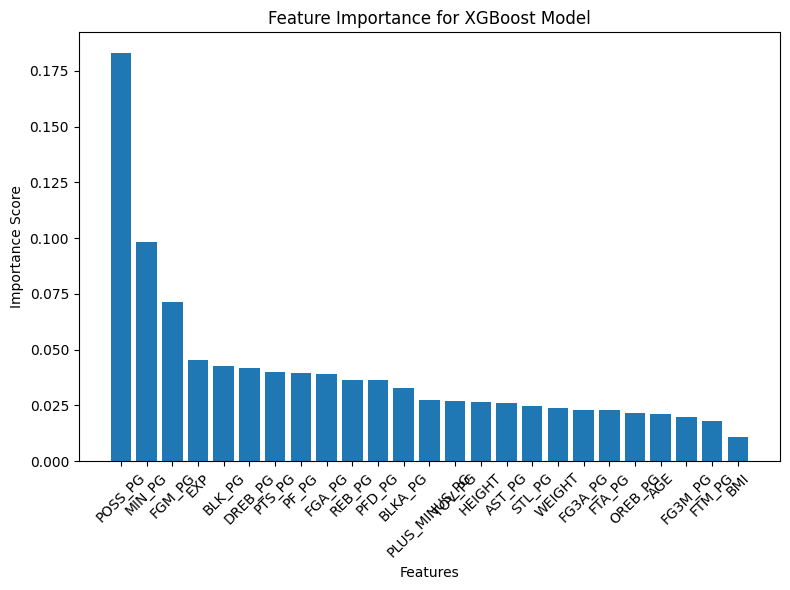

In [ ]:

df = pd.read_csv('data/nba_data_for_train.csv')

# feature_cols = [
#     'MIN_PG', 'PF_PG', 'STL_PG', 'PTS_PG', 'FGM_PG', 'FGA_PG', 'BLK_PG', 
#     'BLKA_PG', 'PLUS_MINUS_PG', 'PFD_PG', 'TOV_PG', 'DREB_PG', 'REB_PG',
#     'OREB_PG', 'FTM_PG', 'FTA_PG', 'EXP', 'AGE', 'HEIGHT', 'WEIGHT',
#     'BMI', 'FG3M_PG', 'FG3A_PG', 'AST_PG'
# ]


#['MIN_PG', 'STL_PG', 'PTS_PG', 'BLK_PG', 'PFD_PG', 'TOV_PG', 'DREB_PG', 'REB_PG', 'OREB_PG', 'PF_PG', 'EXP', 'AGE', 'HEIGHT', 'WEIGHT', 'FGM_PG', 'FGA_PG', 'POSS_PG']


# Added compared to Seasonal 'PLUS_MINUS_PG', 'POSS_PG', 'BMI', 'PLUS_MINUS_PG'
# Removed compared to seasonal: 'FG3M_PG','FG3A_PG','AST_PG', 'FTA_PG', 'FTM_PG', "Team_Id", "BLKA"


feature_cols = ['MIN_PG', 'STL_PG', 'PTS_PG', 'FGM_PG', 'FGA_PG', 'BLK_PG', 'PLUS_MINUS_PG', 'PF_PG', 'PFD_PG', 'TOV_PG', 'DREB_PG', 'REB_PG', 'OREB_PG', 'EXP', 'POSS_PG', 'AGE', 'HEIGHT', 'WEIGHT', 'BMI', 'FG3M_PG','FG3A_PG','AST_PG', 'FTA_PG', 'FTM_PG', "BLKA_PG"]


target_col = 'Games Missed'

X = df[feature_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgbr = XGBRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=xgbr,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # or another appropriate regression metric
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)

y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R2:   {r2:.4f}")

importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
})

feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print("\nFeature Importances (highest to lowest):")
print(feature_importance_df)

plt.figure(figsize=(8, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title("Feature Importance for XGBoost Model")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)  # Rotate feature names for clarity
plt.tight_layout()       # Adjust layout so everything fits nicely
plt.show()

# Final Model with the Best of Features

RMSE: 12.3984
MAE:  8.8575
R2:   0.1444

Feature Importances (highest to lowest):
   Feature  Importance
2      FGM    0.099727
16     EXP    0.097203
15     PTS    0.074648
8     DREB    0.068947
7     OREB    0.059507
5      FTM    0.056198
11     STL    0.053446
1      FGA    0.052577
10     TOV    0.051855
4     FG3A    0.045163
6      FTA    0.043686
0      AGE    0.040656
14     PFD    0.040560
9      AST    0.040216
18  WEIGHT    0.038406
3     FG3M    0.037923
12     BLK    0.037019
17  HEIGHT    0.033781
13    BLKA    0.028481


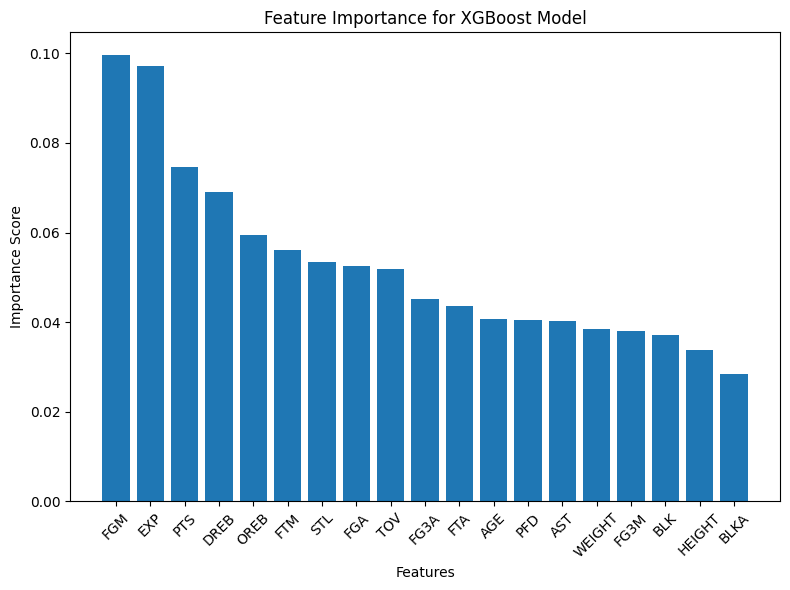

In [ ]:
df = pd.read_csv('data/df_train_without_pg.csv')

# 'MIN', 'REB', 'PF'
feature_cols = ['AGE','FGA', 'FGM', 'FG3M','FG3A','FTM','FTA','OREB','DREB', 'AST',
                 'TOV','STL','BLK','BLKA','PFD','PTS','EXP','HEIGHT','WEIGHT' ]

target_col = 'Games Missed'

X = df[feature_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

xgbr = XGBRegressor(
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    subsample=0.8,
    random_state=42 
)

# Fit the model
xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R2:   {r2:.4f}")

importances = xgbr.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
})

feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print("\nFeature Importances (highest to lowest):")
print(feature_importance_df)

plt.figure(figsize=(8, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title("Feature Importance for XGBoost Model")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45) 
plt.tight_layout()       
plt.show()

# Evaluate Feature Importance with SHAP Value

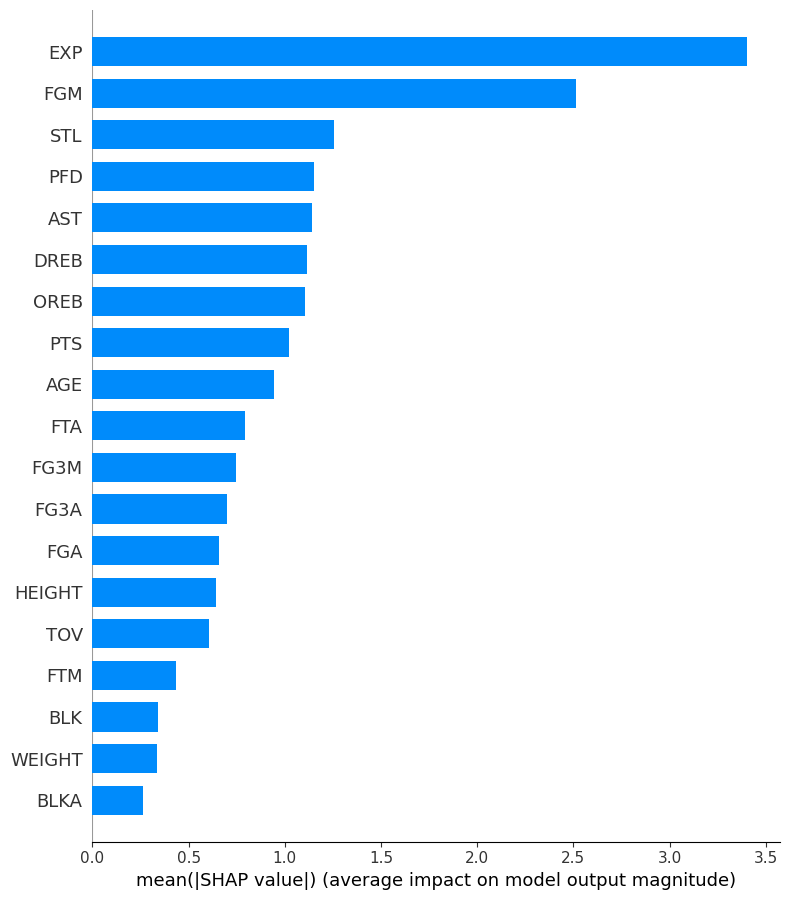

In [ ]:
# SHAP explainer
explainer = shap.Explainer(xgbr, X_train)
shap_values = explainer(X_test)

# Summary Plot (Feature Importance across the entire test set)
plt.title("SHAP Summary Plot (All Features)")
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("shap_summary_plot_all_features.png", bbox_inches='tight', dpi=300)
plt.show()

# Bar Plot of Mean Absolute SHAP Value for each feature
plt.title("Mean Absolute SHAP Value (Feature Importance)")
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.savefig("Mean Absolute SHAP Value.png", bbox_inches='tight', dpi=300)
plt.show()

# Sensitivity Analysis

- Using Partial Dependence to Evaluate Top Features' Individual Trends against Injury Prediction

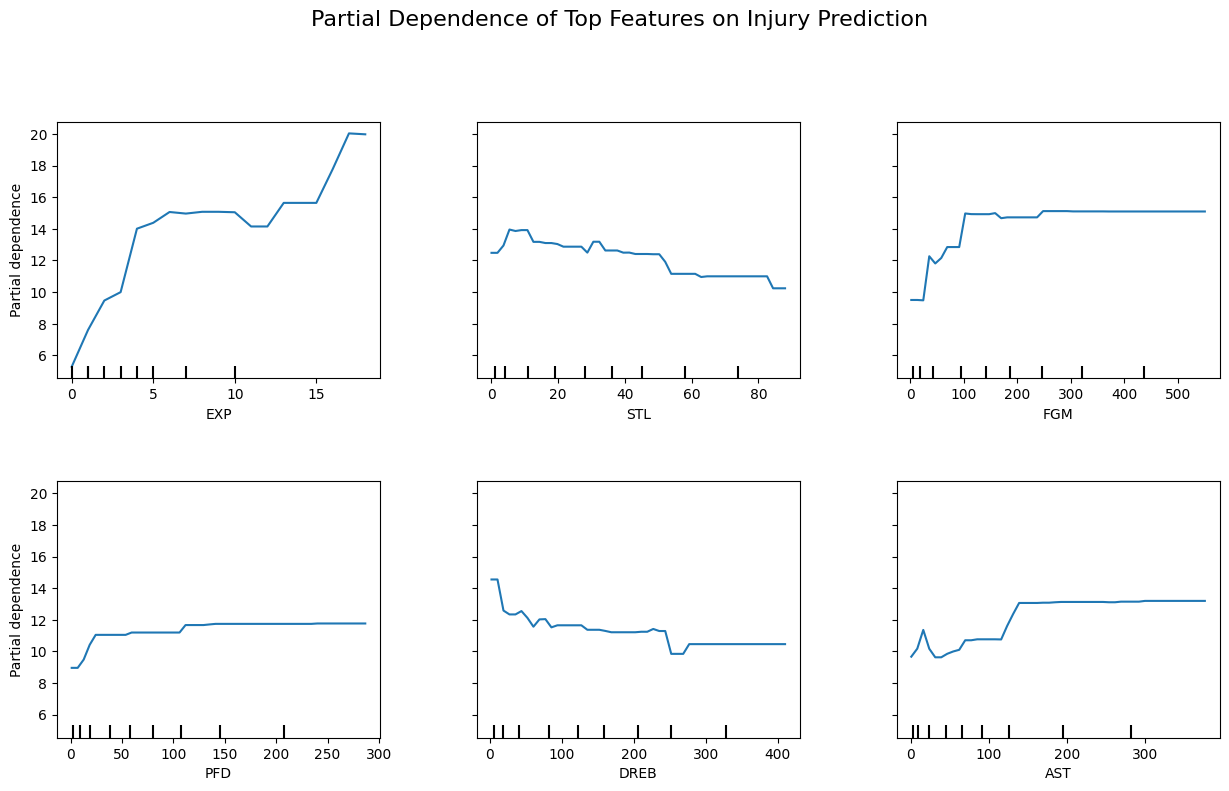

In [ ]:
top_features = ['EXP', 'STL', 'FGM', 'PFD', 'DREB', 'AST']

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))  
disp = PartialDependenceDisplay.from_estimator(
    xgbr,
    X_test,
    features=top_features,
    kind="average",
    grid_resolution=50,
    ax=ax
)

fig.suptitle("Partial Dependence of Top Features on Injury Prediction", fontsize=16, y=1.02)
plt.subplots_adjust(hspace=0.4, wspace=0.3) 
plt.show()

# Exporting SHAP Values for Dashboard Building

In [ ]:
mean_abs_shap = np.mean(np.abs(shap_values.values), axis=0)

shap_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_Absolute_SHAP': mean_abs_shap
})

shap_importance_df.sort_values(
    by='Mean_Absolute_SHAP', 
    ascending=False, 
    inplace=True
)

shap_importance_df

,Feature,Mean_Absolute_SHAP
16,EXP,3.403694
2,FGM,2.513419
11,STL,1.257744
14,PFD,1.153725
9,AST,1.138576
8,DREB,1.116788
7,OREB,1.105137
15,PTS,1.021408
0,AGE,0.941228
6,FTA,0.792512


In [ ]:
shap_importance_df.to_csv('data/shap.csv', index=False)